<a href="https://colab.research.google.com/github/kknd4eva/generative_music/blob/develop/Copy_of_music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 6.3 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=655a39faca142b00642a11e255ea8929061a2e778e0c68d92a2ffaa6b07371a7
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty-midi


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 1701
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 8000 * 4

## Download the Maestro dataset

In [ ]:
data_dir = pathlib.Path('data/bach')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'chopin.zip',
      origin='https://cloudyskies.s3.ap-southeast-2.amazonaws.com/chopin.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

315789/315789 [==============================] - 1s 2us/step


The dataset contains about 1,200 MIDI files.

In [ ]:
filenames = glob.glob(str('data/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 48


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [ ]:
sample_file = filenames[1]
print(sample_file)

data/chpn-p3.mid


Generate a `PrettyMIDI` object for the sample MIDI file.

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=60):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
for instrument in pm.instruments:
  name = pretty_midi.program_to_instrument_name(instrument.program)
  print('Instrument name:', name)

Number of instruments: 2
Instrument name: Acoustic Grand Piano
Instrument name: Acoustic Grand Piano


## Extract notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=43, note_name=G2, duration=0.0927
1: pitch=50, note_name=D3, duration=0.0934
2: pitch=55, note_name=G3, duration=0.0932
3: pitch=57, note_name=A3, duration=0.0930
4: pitch=59, note_name=B3, duration=0.1082
5: pitch=57, note_name=A3, duration=0.1080
6: pitch=55, note_name=G3, duration=0.1078
7: pitch=64, note_name=E4, duration=0.1074
8: pitch=62, note_name=D4, duration=0.1071
9: pitch=60, note_name=C4, duration=0.1074


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     62  2.964416  3.523432  0.000000  0.559016
1     67  3.708048  4.261525  0.743632  0.553477
2     71  3.708048  4.261525  0.000000  0.553477
3     76  4.354500  4.447668  0.646452  0.093168
4     72  4.354500  4.447668  0.000000  0.093168

It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E5', 'E5', 'E5', 'E5', 'F5', 'G5', 'E5', 'C5', 'D5', 'E5'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

Plot the notes for the entire track.

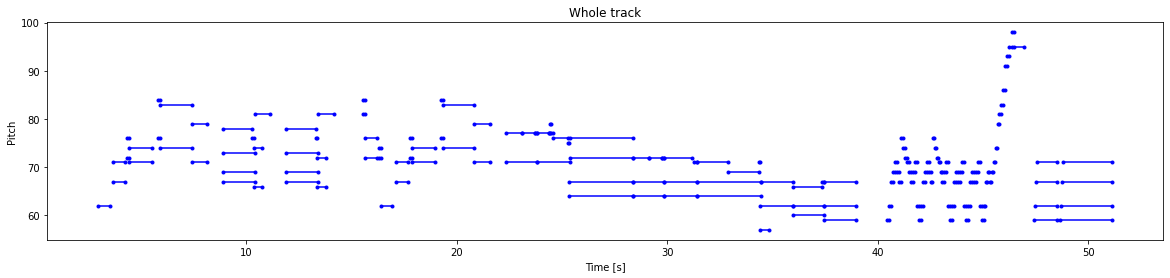

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

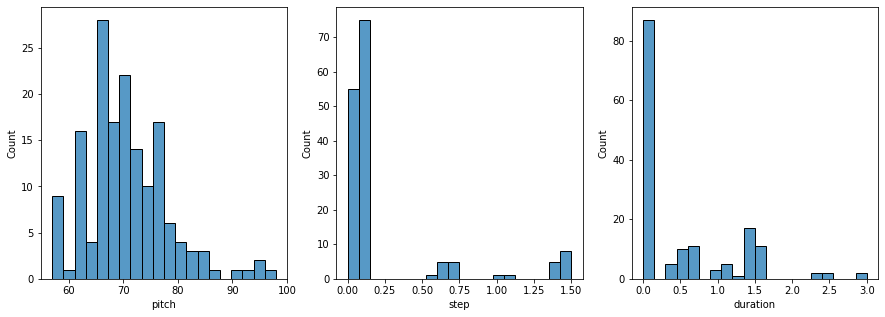

In [ ]:
plot_distributions(raw_notes)

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [ ]:
num_files = 48
all_notes = []
for f in filenames[:num_files]:
  try:
    notes = midi_to_notes(f)
    all_notes.append(notes)
  except Exception as e:
      print(f'Skipping MIDI file {f}: {e}')
      continue
    # process the MIDI data
  print(f'Processing MIDI file {f}')
print('Finished processing MIDI files')
all_notes = pd.concat(all_notes)

Processing MIDI file data/chpn_op25_e2.mid
Processing MIDI file data/chpn-p3.mid
Processing MIDI file data/chpn_op35_3.mid
Processing MIDI file data/chpn-p23.mid
Processing MIDI file data/chpn-p24.mid
Processing MIDI file data/chpn-p15.mid
Processing MIDI file data/chpn-p16.mid
Processing MIDI file data/chpn-p17.mid
Processing MIDI file data/chpn-p4.mid
Processing MIDI file data/chp_op31.mid
Processing MIDI file data/chpn_op27_2.mid
Processing MIDI file data/chpn_op25_e12.mid
Processing MIDI file data/chpn_op66.mid
Processing MIDI file data/chpn-p10.mid
Processing MIDI file data/chp_op18.mid
Processing MIDI file data/chpn_op10_e12.mid
Processing MIDI file data/chpn-p5.mid
Processing MIDI file data/chpn-p22.mid
Processing MIDI file data/chpn-p13.mid
Processing MIDI file data/chpn-p6.mid
Processing MIDI file data/chpn_op53.mid
Processing MIDI file data/chpn_op10_e01.mid
Processing MIDI file data/chpn-p18.mid
Processing MIDI file data/chpn-p11.mid
Processing MIDI file data/chpn-p9.mid
Pro

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 40305


Next, create a `tf.data.Dataset` from the parsed notes.

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
np.shape(train_notes)

(40305, 3)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [ ]:
seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.5625     0.         0.32570604]
 [0.5625     0.32570604 0.11146331]
 [0.5703125  0.0990785  0.11118238]
 [0.5546875  0.09885375 0.11089833]
 [0.5625     0.098629   0.10997948]
 [0.5859375  0.09815467 0.10642331]
 [0.5703125  0.0945985  0.0952585 ]
 [0.5625     0.0952585  0.11100331]
 [0.5703125  0.0986185  0.11118238]
 [0.5546875  0.09885375 0.11066117]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.09862900000000074>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.110032270833333>}


Batch the examples, and configure the dataset for performance.

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

628/628 [==============================] - 49s 64ms/step - loss: 5.6461 - duration_loss: 0.3852 - pitch_loss: 4.8545 - step_loss: 0.4064


{'loss': 5.646106719970703,
 'duration_loss': 0.385224312543869,
 'pitch_loss': 4.854521751403809,
 'step_loss': 0.4063624143600464}

One way balance this is to use the `loss_weights` argument to compile:

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
      'pitch': 0.05,
      'step': 0.7,
      'duration':0.7,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [ ]:
model.evaluate(train_ds, return_dict=True)

628/628 [==============================] - 40s 62ms/step - loss: 0.9552 - duration_loss: 0.3852 - pitch_loss: 4.8545 - step_loss: 0.4064


{'loss': 0.9551535248756409,
 'duration_loss': 0.385224312543869,
 'pitch_loss': 4.854521751403809,
 'step_loss': 0.4063624143600464}

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
628/628 [==============================] - 92s 143ms/step - loss: 0.4721 - duration_loss: 0.1058 - pitch_loss: 3.7389 - step_loss: 0.3016
Epoch 2/50
628/628 [==============================] - 93s 147ms/step - loss: 0.4494 - duration_loss: 0.0988 - pitch_loss: 3.5661 - step_loss: 0.2885
Epoch 3/50
628/628 [==============================] - 90s 144ms/step - loss: 0.4341 - duration_loss: 0.0973 - pitch_loss: 3.3541 - step_loss: 0.2833
Epoch 4/50
628/628 [==============================] - 90s 144ms/step - loss: 0.4227 - duration_loss: 0.0948 - pitch_loss: 3.2124 - step_loss: 0.2795
Epoch 5/50
367/628 [================>.............] - ETA: 37s - loss: 0.4847 - duration_loss: 0.0962 - pitch_loss: 3.1715 - step_loss: 0.3696

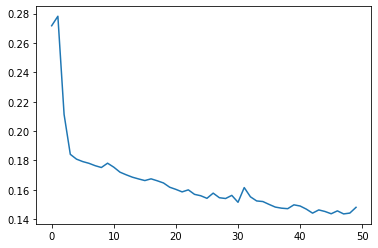

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [ ]:
temperature = 9
num_predictions = 300

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 19ms/step


In [ ]:
generated_notes.head(100)

pitch      step  duration       start         end
0      64  0.288282  0.320328    0.288282    0.608610
1      75  0.922141  0.797158    1.210423    2.007581
2      74  0.970288  0.649580    2.180711    2.830291
3      72  0.985984  0.609123    3.166695    3.775818
4      77  1.005092  0.605551    4.171787    4.777339
..    ...       ...       ...         ...         ...
95     71  1.130045  0.646575  105.853476  106.500050
96     73  1.130717  0.622443  106.984193  107.606636
97     73  1.129314  0.630936  108.113507  108.744443
98     74  1.129641  0.631213  109.243148  109.874361
99     72  1.129627  0.633244  110.372775  111.006019

[100 rows x 5 columns]

In [ ]:
out_file = 'output1.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')
display_audio(out_pm)

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

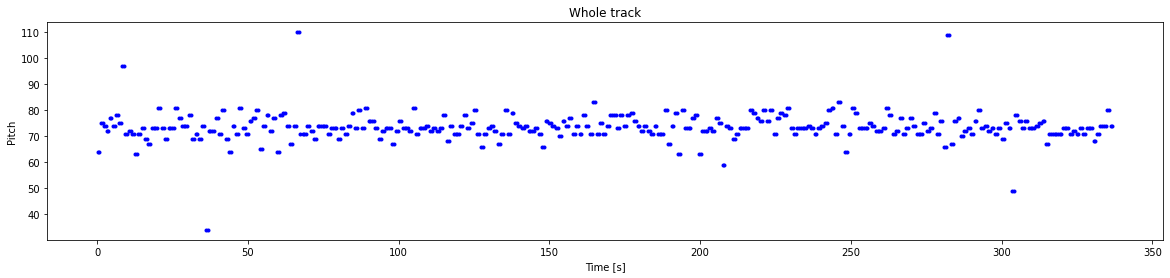

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

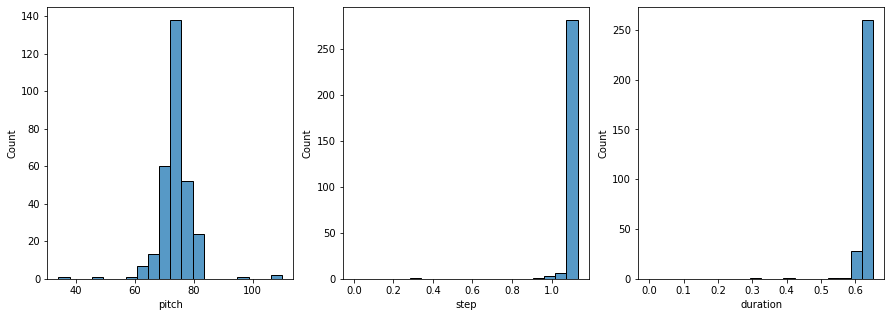

In [ ]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).